In [2]:
import torch
import torchvision
from PIL import Image
import numpy as np
import matplotlib.pyplot as plt
import urllib.request

from transformers import AutoImageProcessor, ResNetForImageClassification

/home/kulac/projects/ML/venv/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
2025-01-02 09:05:41.204023: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2025-01-02 09:05:41.212163: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1735826741.222162   10287 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1735826741.225311   10287 cuda_blas.cc:1418] U

In [3]:
if torch.cuda.is_available():
    print("CUDA is available. PyTorch can use the GPU.")
    print(f"Number of GPUs available: {torch.cuda.device_count()}")
    print(f"GPU Name: {torch.cuda.get_device_name(0)}")
else:
    print("CUDA is not available. PyTorch cannot use the GPU.")

CUDA is available. PyTorch can use the GPU.
Number of GPUs available: 1
GPU Name: NVIDIA GeForce RTX 4070 Ti SUPER


In [4]:
def prep_input(path):
    image = Image.open(path)

    preprocess = torchvision.transforms.Compose([
        torchvision.transforms.Resize(256),
        torchvision.transforms.CenterCrop(224),
        torchvision.transforms.ToTensor(),
        torchvision.transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
    ])

    image = preprocess(image)
    image.unsqueeze_(0)

    return image

In [5]:
def decode_output(output):
    # taken and modified from https://pytorch.org/hub/pytorch_vision_alexnet/
    url = "https://raw.githubusercontent.com/pytorch/hub/master/imagenet_classes.txt"
    urllib.request.urlretrieve(url, "imagenet_classes.txt")

    # Read the categories
    probabilities = torch.nn.functional.softmax(output[0], dim=0)

    with open("imagenet_classes.txt", "r") as f:
        categories = [s.strip() for s in f.readlines()]

    # Show top categories per image
    top5_prob, top5_catid = torch.topk(probabilities, 5)
    for i in range(top5_prob.size(0)):
        print(categories[top5_catid[i]], top5_prob[i].item())

    return top5_catid[0]

In [6]:
def prep_output(img_tensor):
    invTrans = torchvision.transforms.Compose([
        torchvision.transforms.Normalize(
            mean = [ 0., 0., 0. ],
            std = [ 1/0.229, 1/0.224, 1/0.225 ]
        ),
        torchvision.transforms.Normalize(
            mean = [ -0.485, -0.456, -0.406 ],
            std = [ 1., 1., 1. ]
        ),
    ])

    out = invTrans(img_tensor)[0]
    out = out.detach().numpy().transpose(1, 2, 0)

    return out

In [7]:
def plot_maps(img1, img2,vmin=0.3,vmax=0.7, mix_val=2):
    f = plt.figure(figsize=(45,15))
    plt.subplot(1,3,1)
    plt.imshow(img1,vmin=vmin, vmax=vmax, cmap="gray")
    plt.axis("off")
    plt.subplot(1,3,2)
    plt.imshow(img2, cmap = "gray")
    plt.axis("off")
    plt.subplot(1,3,3)
    plt.imshow(img1*mix_val+img2/mix_val, cmap = "gray" )
    plt.axis("off")
    plt.show()

In [8]:
def norm_flat_image(img):
    grads_norm = img[0].detach().numpy().transpose(1, 2, 0) #prep_output(img)
    grads_norm = grads_norm[:,:,0] + grads_norm[:,:,1] + grads_norm[:,:,2]
    grads_norm = (grads_norm - np.min(grads_norm)) / (np.max(grads_norm) - np.min(grads_norm))

    return grads_norm

In [9]:
test_model = ResNetForImageClassification.from_pretrained("microsoft/resnet-50")
test_model.eval()

ResNetForImageClassification(
  (resnet): ResNetModel(
    (embedder): ResNetEmbeddings(
      (embedder): ResNetConvLayer(
        (convolution): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
        (normalization): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (activation): ReLU()
      )
      (pooler): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    )
    (encoder): ResNetEncoder(
      (stages): ModuleList(
        (0): ResNetStage(
          (layers): Sequential(
            (0): ResNetBottleNeckLayer(
              (shortcut): ResNetShortCut(
                (convolution): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
                (normalization): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
              )
              (layer): Sequential(
                (0): ResNetConvLayer(
                  (convolution): Conv2d(64

In [12]:
def relu_hook_function(module, grad_in, grad_out):
    if isinstance(module, torch.nn.ReLU):
        return (torch.clamp(grad_in[0], min=0.),)


In [11]:
input_img = prep_input("images/lion.jpg")

In [13]:
count = 0
#relu in embedder layer
if isinstance(test_model.resnet.embedder.embedder.activation, torch.nn.ReLU):
    count += 1

#relu in each stage
print("#stages", len(test_model.resnet.encoder.stages),'\n')
for idx_stages, stage in enumerate(test_model.resnet.encoder.stages):
    print(f"stage {idx_stages} #bottleNecklayers:", len(stage.layers))
    for bottleNeckLayer in stage.layers:
        if isinstance(bottleNeckLayer.activation, torch.nn.ReLU):
            count += 1
        for ResNetConvLayer in bottleNeckLayer.layer:
            if isinstance(ResNetConvLayer.activation, torch.nn.ReLU):
                count += 1

count

#stages 4 

stage 0 #bottleNecklayers: 3
stage 1 #bottleNecklayers: 4
stage 2 #bottleNecklayers: 6
stage 3 #bottleNecklayers: 3


49

In [14]:
#relu in embedder layer
test_model.resnet.embedder.embedder.activation.register_backward_hook(relu_hook_function)

#relu in each stage
for idx_stages, stage in enumerate(test_model.resnet.encoder.stages):
    print(f"stage {idx_stages} #bottleNecklayers:", len(stage.layers))
    for bottleNeckLayer in stage.layers:
        bottleNeckLayer.activation.register_backward_hook(relu_hook_function)
        for ResNetConvLayer in bottleNeckLayer.layer:
            ResNetConvLayer.activation.register_backward_hook(relu_hook_function)

stage 0 #bottleNecklayers: 3
stage 1 #bottleNecklayers: 4
stage 2 #bottleNecklayers: 6
stage 3 #bottleNecklayers: 3


In [21]:
input_img.requires_grad = True

# forward/inference
out = test_model(input_img).logits

In [22]:
best_id = decode_output(out)

lion 0.9999343156814575
hyena 4.621959760697791e-06
tiger 1.5858470305829542e-06
zebra 1.0869005109270802e-06
cheetah 1.0572564406174934e-06


In [23]:
# backprop
out[0, best_id].backward()
grads = input_img.grad

grads.shape

torch.Size([1, 3, 224, 224])

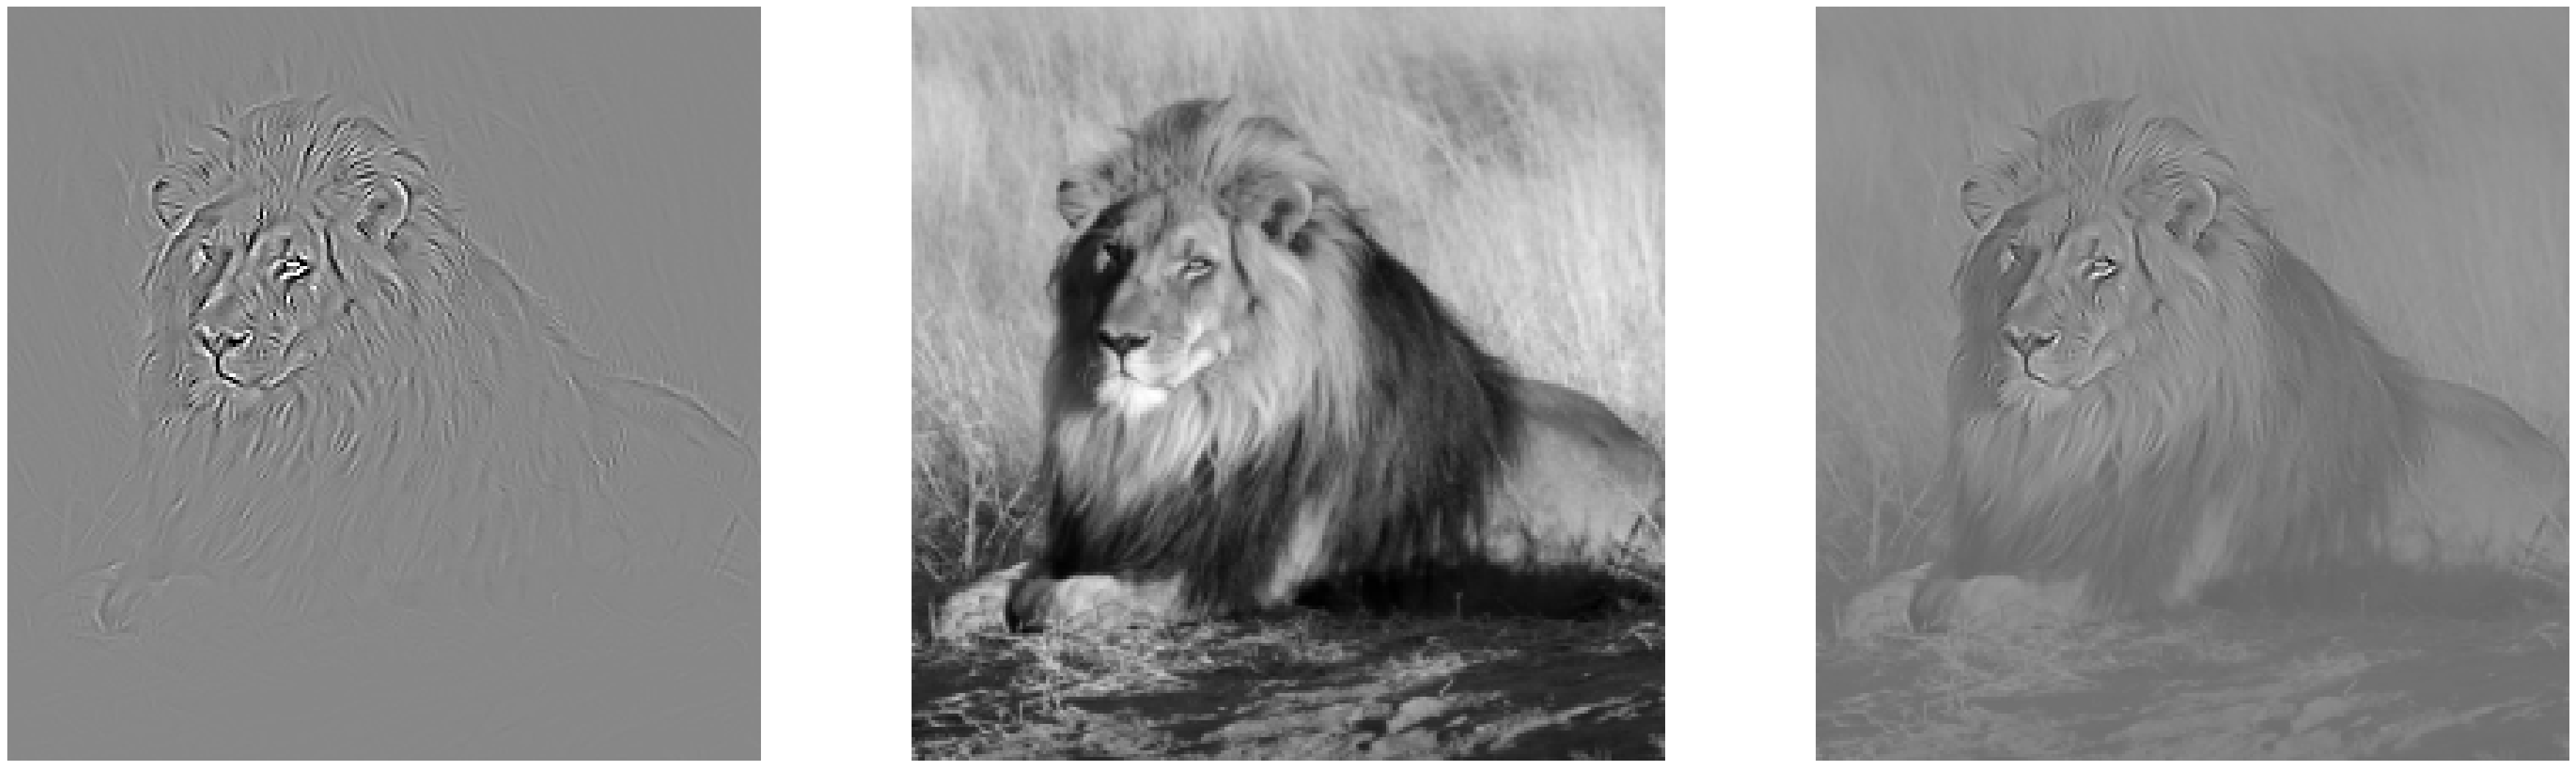

In [24]:
plot_maps(norm_flat_image(grads), norm_flat_image(input_img))